<a href="https://colab.research.google.com/github/A243086/A243086/blob/main/Copy_of_ECG_SIGNAL_PROCESS_TO_IDENTIFY_ABNORMAL_HEART_RYTHM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import the necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model



from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('confusion matrix')
    print(confusion)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

In [ ]:
from pandas.io.parsers.readers import DataFrame
# loading the dataset

DataFrame = pd. read_csv ('/content/ecg.csv',header=None)
raw_data = DataFrame.values
DataFrame.head().style.set_properties(**{'background-color': 'purple',
                           'color': 'white',
                           'border-color': 'black'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,-0.493223,-0.463052,-0.301644,-0.232734,-0.125055,-0.153943,-0.024357,-0.065609,0.034999,0.061935,0.071195,0.123925,0.103124,0.225228,0.128683,0.302483,0.257276,0.196352,0.179383,0.244729,0.341217,0.328204,0.406042,0.446605,0.424068,0.481512,0.477844,0.624083,0.574585,0.598013,0.564592,0.607979,0.620635,0.656253,0.684748,0.694273,0.665584,0.575796,0.638135,0.614917,0.569083,0.468576,0.442818,0.468274,0.432493,0.407958,0.418623,0.362531,0.410959,0.471666,0.372167,0.337875,0.221405,0.273997,0.298664,0.263564,0.342564,0.419505,0.586607,0.860624,1.173345,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.000000
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,-0.206160,-0.224480,-0.048684,-0.019621,0.094805,0.116786,0.185186,0.230526,0.138027,0.244426,0.271695,0.259003,0.269202,0.127065,0.202073,0.255983,0.153115,0.210216,0.191082,0.190927,0.210510,0.207108,0.204888,0.200865,0.346920,0.348002,0.254537,0.331975,0.356690,0.349930,0.430380,0.467502,0.486063,0.403188,0.478956,0.397392,0.464120,0.451795,0.361361,0.379831,0.342785,0.399107,0.387508,0.255703,0.284034,0.284993,0.250108,0.173036,0.149423,0.141685,0.222261,0.172847,0.150779,0.176566,0.280942,0.489939,0.660889,0.893193,1.026997,1.202394,1.557410,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.000000
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,-0.438023,-0.436248,-0.400114,-0.134987,-0.239347,-0.120244,-0.001971,0.285000,0.315646,0.107364,0.109521,0.158078,0.291898,0.261294,0.188407,0.140651,0.263365,0.287207,0.314317,0.177942,0.138290,0.321069,0.458168,0.251916,0.261353,0.277488,0.298793,0.459075,0.419147,0.520509,0.537761,0.603211,0.475634,0.521693,0.735248,0.729541,0.718523,0.498433,0.545441,0.604827,0.521296,0.394381,0.405020,0.597563,0.531130,0.377651,0.467701,0.457569,0.341116,0.407913,0.459127,0.403937,0.298191,0.46110

In [ ]:
# check the data distribution if balanced

colors = ['red', 'blue']
labels = ['Normal','Abnormal']
values = DataFrame[140].value_counts()/DataFrame[140].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='white', width=0.1)))
fig.update_layout(
    title_text="ECG dataset",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)
fig.show()

In [ ]:
# Divide the data set

# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)


In [ ]:
# data preprocessing
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
# we need to train the autoencoder to take normal rythm as label 1 
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

print("the length of train :",len(train_labels))
print("the length of test :",len(test_labels))

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]


the length of train : 3998
the length of test : 1000


Text(0.5, 1.0, 'A Normal Rythm')

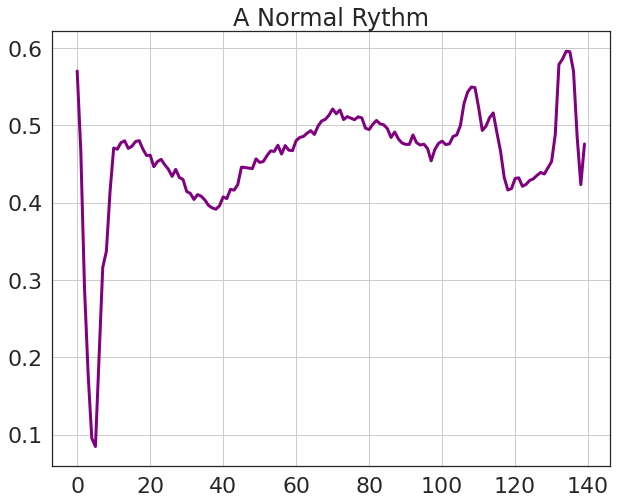

In [ ]:
# ECG plot for normal rythm
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), normal_train_data[0],color='purple',linewidth=3.0)
plt.title("A Normal Rythm")


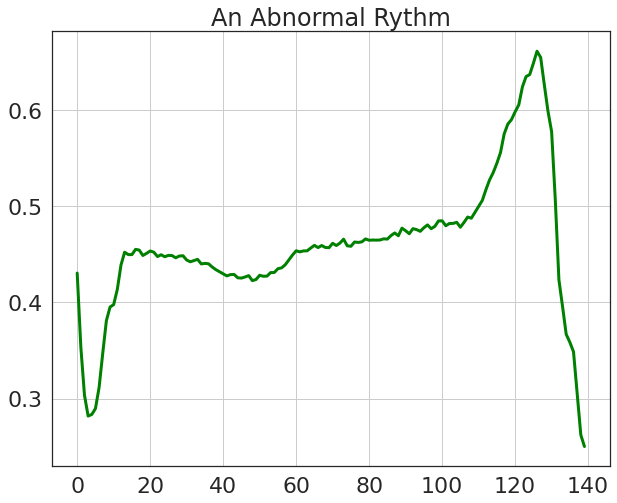

In [ ]:
# ECG plot for Abnormal rythm
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0],color='green',linewidth=3.0)
plt.title("An Abnormal Rythm")
plt.show()

In [ ]:
# Let us build our Model

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
# train the autoencoder
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=50, 
          batch_size=100,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0202 - val_loss: 0.0332
Epoch 2/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0200 - val_loss: 0.0326
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0198 - val_loss: 0.0325
Epoch 4/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0196 - val_loss: 0.0320
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0194 - val_loss: 0.0313
Epoch 6/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0192 - val_loss: 0.0308
Epoch 7/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0189 - val_loss: 0.0303
Epoch 8/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0185 - val_loss: 0.0296
Epoch 9/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0180 - val_loss: 0.0295
Epoch 10/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0175 - val_loss: 0.0291
Epoch 11/50
24/24 [

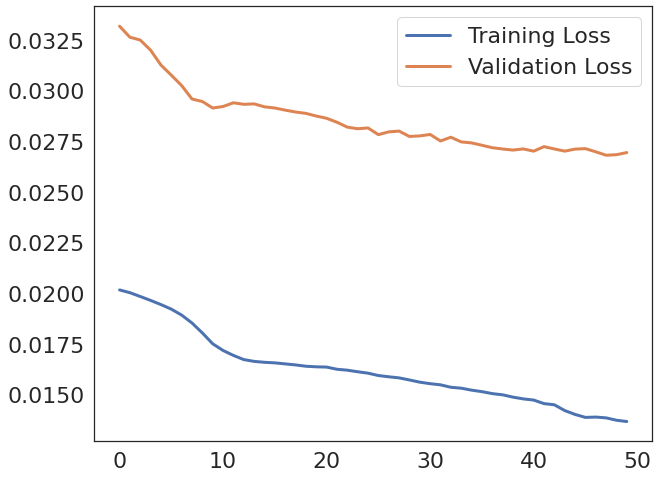

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

classify the ECG as abnormal If the reconstruction error is greater than one standard deviation from the normal training example. plot the normal ECG of the training set, the reconstruction after being encoded and decoded by the autoencoder, and the reconstruction error.

In [ ]:
encoded_imgs_normal = pd.DataFrame(encoded_imgs)
encoded_imgs_normal['label'] = 1

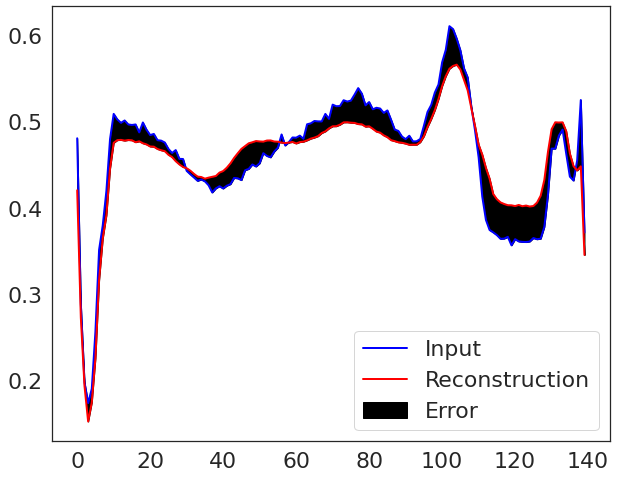

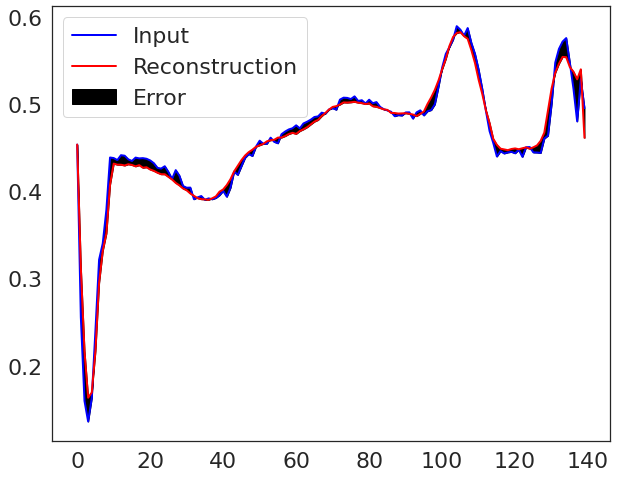

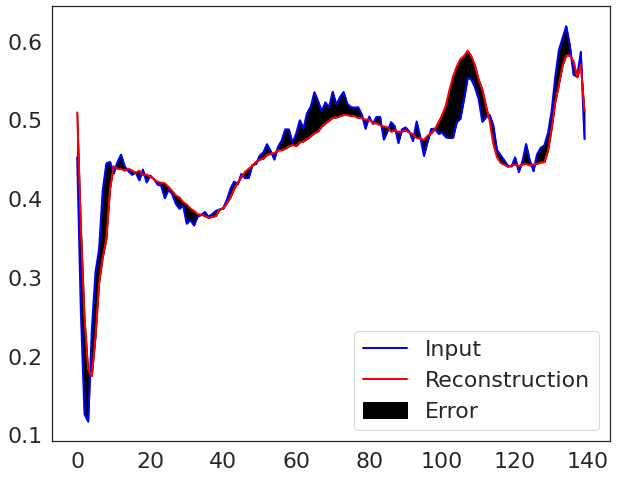

In [ ]:
# Testing with Normal rythm

encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0,3):
    plt.figure(figsize=(10,8))
    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.plot(normal_test_data[i], 'blue',linewidth=2)
    plt.plot(decoded_imgs[i], 'red',linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], normal_test_data[i], color='black')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

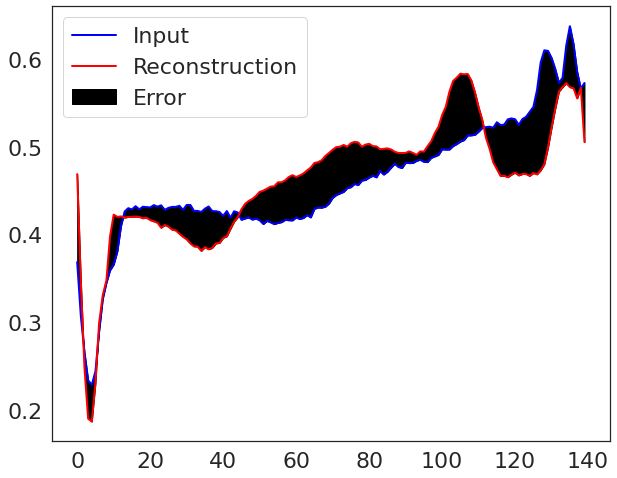

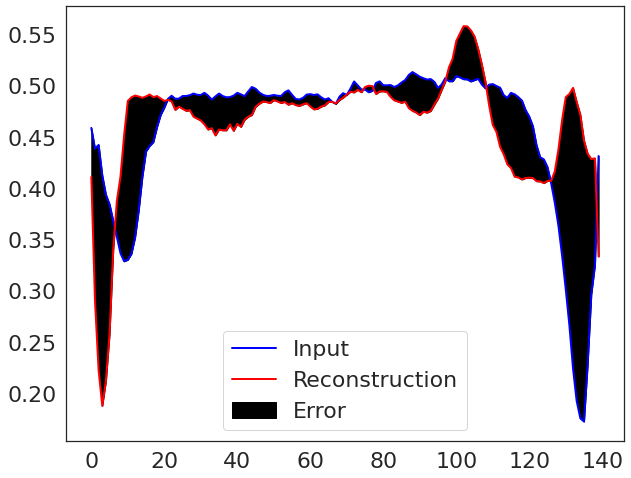

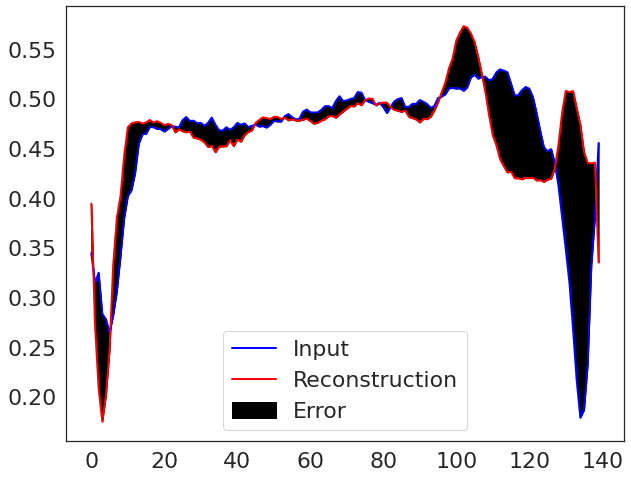

In [ ]:
# test with the abnormal rythm

encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0,3):
    plt.figure(figsize=(10,8))
    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.plot(anomalous_test_data[i], 'blue',linewidth=2)
    plt.plot(decoded_imgs[i], 'red',linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], anomalous_test_data[i], color='black')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [ ]:
encoded_imgs_abnormal = pd.DataFrame(encoded_imgs)
encoded_imgs_abnormal['label'] = 0

In [ ]:
# Detecting Anomaly
# Plot the reconstruction error for normal ECGs in the training set.

reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
np.mean(train_loss)

74/74 [==============================] - 0s 2ms/step


0.013753405

Reconstruction loss is calculated and anomalies are detected if it's higher than a certain threshold. Here, we calculate the mean error for normal examples in the training set and classify future examples as abnormal if the reconstruction error is greater than the training set standard deviation.

Show the reconstruction error for normal ECGs in the training set.

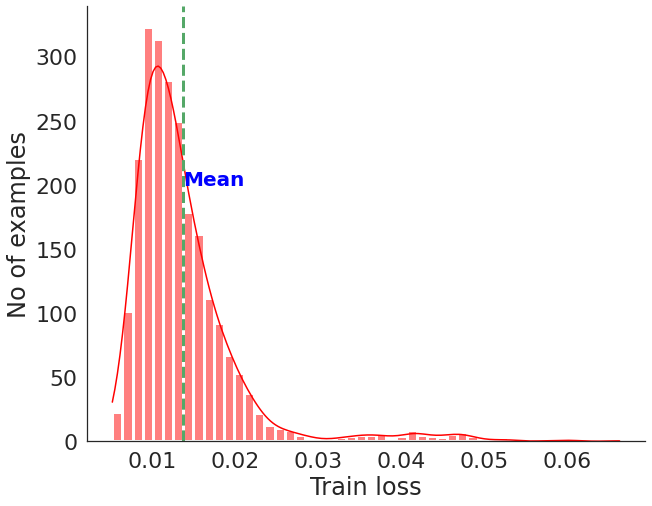

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Mean", horizontalalignment='left', 
         size='small', color='blue', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

In [ ]:
# choosing a threshold higher than the mean

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.02056313


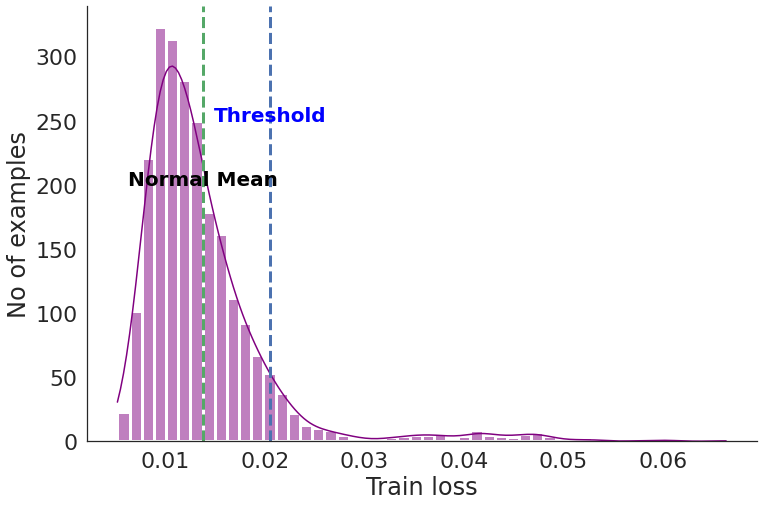

In [ ]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='purple',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

In the test set, reconstruction errors for unusual examples are consistently greater than the threshold (blue-dotted line=0.02

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

14/14 [==============================] - 0s 2ms/step


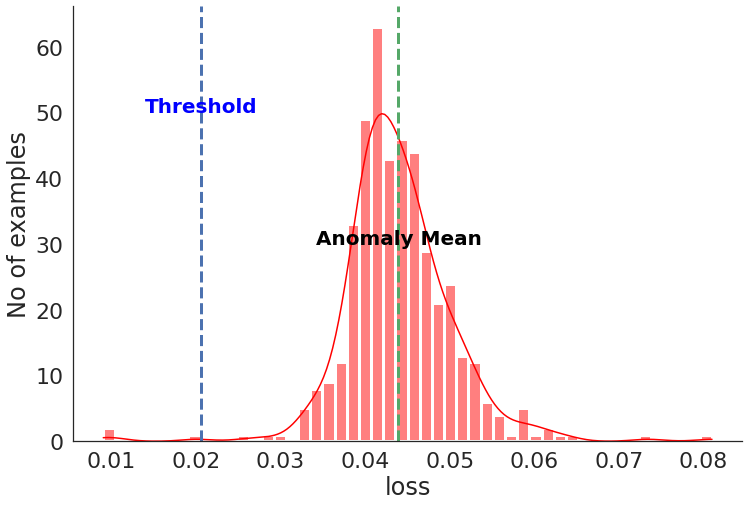

In [ ]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 30, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.text(threshold, 50, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

If the reconstruction error is greater than the threshold(blue-dotted line), classify the ECG as abnormal.

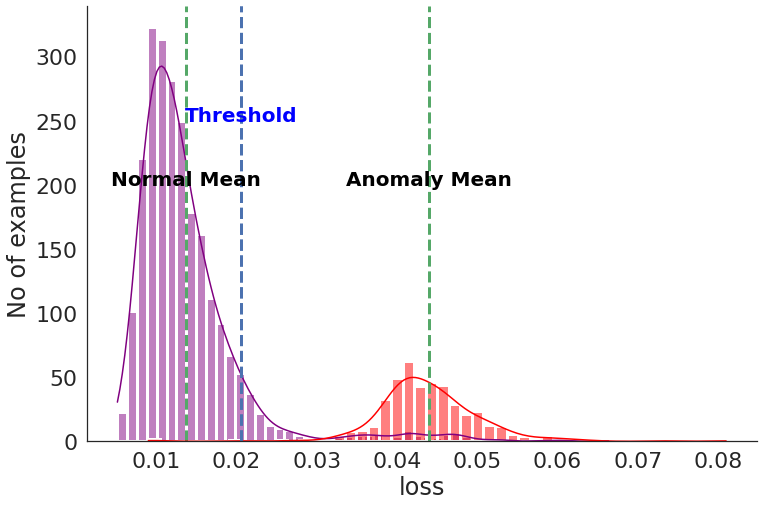

In [ ]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='purple',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')

sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 200, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()


In [ ]:
# make predictions
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.95
Precision = 0.9941860465116279
Recall = 0.9160714285714285


confusion matrix
[[437   3]
 [ 47 513]]
accuracy: 0.9500, precision: 0.9942, recall: 0.9161,    F1: 0.9535, AUC:0.9546


<Axes: >

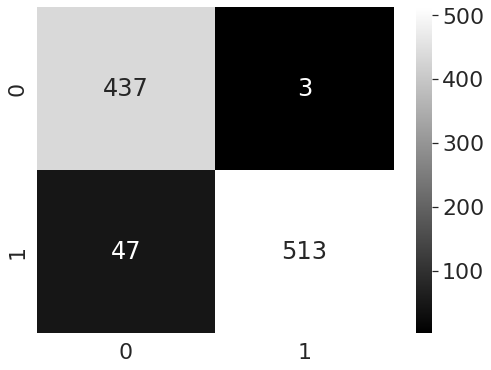

In [ ]:
confusion_matrix = get_clf_eval(test_labels,preds,preds)
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.set_style("white")
sns.heatmap(confusion_matrix, cmap = 'gist_yarg_r',annot = True, fmt='d')


In [ ]:
len(DataFrame.columns)

141

# New section